In [1]:
from denoising_diffusion_pytorch import Unet
from inspect import isfunction
from einops import rearrange
from functools import partial
from torch import nn, einsum
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data.dataloader as dataloader
from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm import tqdm
import random
import math

# Fashion MNIST
This dataset is very similar to MNIST, but instead of 10 digits we have 10 types of clothing. For this pset, the labels are not important, and we are only trying to sample from the data distribution $p_\texttt{data}$. Because we are now in the regime of unsupervised learning, we will only use the 60k datapoint training data and disregard the test data.

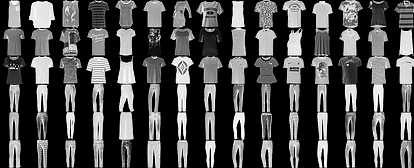

In [2]:
SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 20
LR = 1e-3

device = torch.device("cuda")
train = FashionMNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
train_loader = dataloader.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 26421880/26421880 [00:23<00:00, 1114903.36it/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 335086.11it/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1315950.18it/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



# VAE Architecture
Typically VAEs that operate on images use convolutions and deconvolutions, but in this problem we will simply flatten the input and use an MLP.

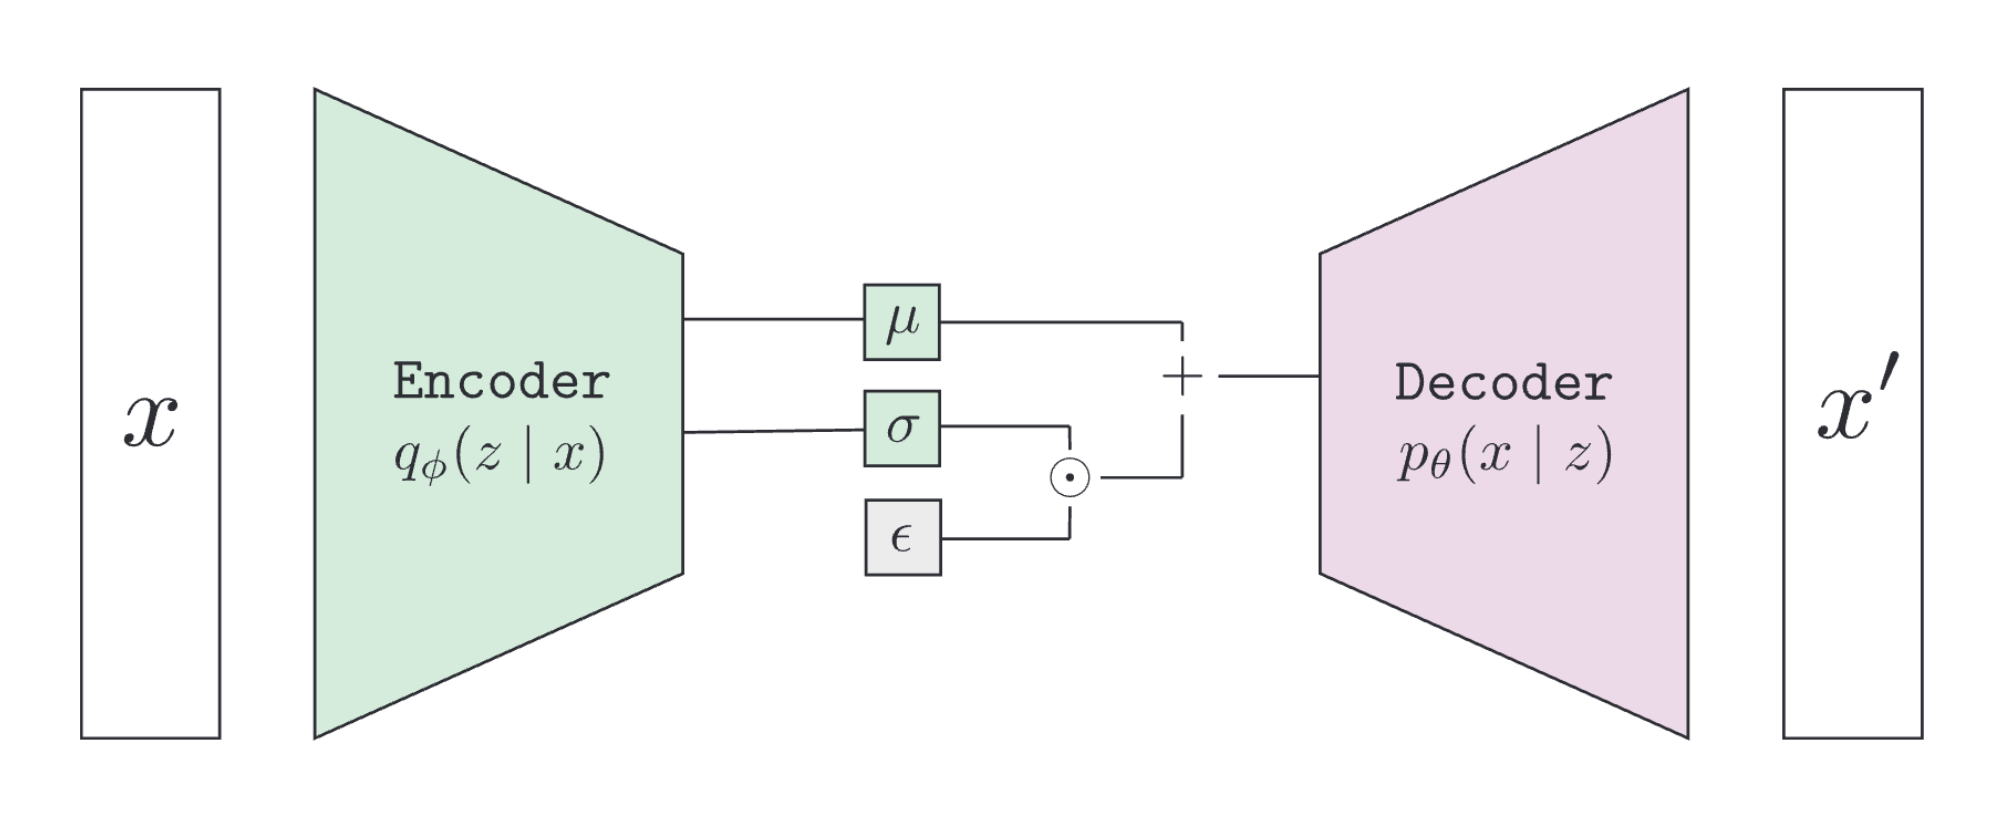

**Question 4:** Implement the VAE architecture
- Inside the `__init__` function you will need to create four modules.
 - The `encoder` module should have two layers with each layer having `num_hidden` hidden units. Both layers should use `nn.ReLU` nonlinearities.
 - The `mu` readout module and `logvar` readout module should be a single linear layer with no nonlinearities that maps from `num_hidden` units to `z_dims` units. `z_dims` is the size of the latent representation.
 - The `decoder` module should have three layers. The first two layers should have `num_hidden` hidden units and `nn.ReLU` nonlinearities, and the last layer should map to the input size and use a `nn.Sigmoid` nonlinearity.  

- The `forward` function is where you should pass your data through those modules according to the figure above. The output of this function should be a 3-tuple containing the reconstructed image, the mean from the `mu` readout module, and the log of the variance from the `logvar` readout module.
  - HINT 1: To create the z that you pass into the decoder, you will need to sample from a zero-mean unit variance gaussian $\epsilon$ with `torch.randn_like`. You latent should be a transformation of that sample as follows:
  $$z=\mu+\sigma\epsilon. $$
This is typically referred to as the "reparameterization trick."
  - HINT 2: For stability during training, the `logvar` readout module does not output the standard deviation directly, but the log of the variance. You will need to transform appropriately when sampling z.

In [11]:
class VAE(nn.Module):
    def __init__(self, z_dims=4, input_size=784, num_hidden=128):
        super().__init__()
        self.z_dims = z_dims
        self.input_size = input_size

        # FIXME: Create two encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_size, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
        )

        # FIXME: Create the mean and logvar readout layers
        self.mu = nn.Linear(num_hidden, z_dims)
        self.logvar = nn.Linear(num_hidden, z_dims)

        # FIXME: Create the decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(z_dims, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # FIXME: Implement the VAE forward function
        x = x.flatten(start_dim=1)
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        # reparameterization trick
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mu + std * epsilon
        output = self.decoder(z)
        return output, mu, logvar

**Question 5:** Train the VAE. A lot of the code for training the VAE is given. You only need to come up with the $L_{\text{ELBO}}$ loss given `x_prime`, `mu`, and `logvar`.
  - HINT: The KL Divergence between two gaussians $q_1=N(\mu_1,\sigma_1)$ and $q_2=N(\mu_2,\sigma_2)$ is defined as follows:

  $$ D_{\text{KL}}(q_1 \parallel q_2) = log\Big(\frac{\sigma_2}{\sigma_1}\Big) + \frac{\sigma_1^2+(\mu_1-\mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$


**Expected runtime is ~10 seconds per epoch**

In [12]:
model = VAE().cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for X, _ in tqdm(train_loader):
        X = X.cuda()
        optimizer.zero_grad()
        x_prime, mu, logvar = model(X)

        # FIXME: Calculate loss
        reconstruction_loss = F.mse_loss(
            x_prime, X.flatten(start_dim=1), reduction="sum"
        )
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # negative ELBO
        loss = reconstruction_loss + kl_divergence

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(
        "Epoch: {} Train Loss: {:.4f}".format(
            epoch, train_loss / len(train_loader.dataset)
        )
    )

  0%|          | 0/469 [00:00<?, ?it/s]

100%|██████████| 469/469 [00:04<00:00, 109.95it/s]


Epoch: 0 Train Loss: 42.4920


100%|██████████| 469/469 [00:04<00:00, 105.37it/s]


Epoch: 1 Train Loss: 28.9299


100%|██████████| 469/469 [00:04<00:00, 116.66it/s]


Epoch: 2 Train Loss: 26.8049


100%|██████████| 469/469 [00:04<00:00, 114.26it/s]


Epoch: 3 Train Loss: 26.0930


100%|██████████| 469/469 [00:04<00:00, 115.54it/s]


Epoch: 4 Train Loss: 25.6519


100%|██████████| 469/469 [00:03<00:00, 117.88it/s]


Epoch: 5 Train Loss: 25.4051


100%|██████████| 469/469 [00:03<00:00, 125.72it/s]


Epoch: 6 Train Loss: 25.1247


100%|██████████| 469/469 [00:03<00:00, 122.88it/s]


Epoch: 7 Train Loss: 24.9774


100%|██████████| 469/469 [00:04<00:00, 111.62it/s]


Epoch: 8 Train Loss: 24.8450


100%|██████████| 469/469 [00:04<00:00, 107.27it/s]


Epoch: 9 Train Loss: 24.7492


100%|██████████| 469/469 [00:04<00:00, 116.29it/s]


Epoch: 10 Train Loss: 24.6158


100%|██████████| 469/469 [00:03<00:00, 118.66it/s]


Epoch: 11 Train Loss: 24.5703


100%|██████████| 469/469 [00:04<00:00, 109.46it/s]


Epoch: 12 Train Loss: 24.5048


100%|██████████| 469/469 [00:03<00:00, 124.89it/s]


Epoch: 13 Train Loss: 24.3969


100%|██████████| 469/469 [00:03<00:00, 120.77it/s]


Epoch: 14 Train Loss: 24.3732


100%|██████████| 469/469 [00:04<00:00, 112.86it/s]


Epoch: 15 Train Loss: 24.3081


100%|██████████| 469/469 [00:04<00:00, 111.49it/s]


Epoch: 16 Train Loss: 24.2646


100%|██████████| 469/469 [00:04<00:00, 115.93it/s]


Epoch: 17 Train Loss: 24.2259


100%|██████████| 469/469 [00:04<00:00, 117.25it/s]


Epoch: 18 Train Loss: 24.1601


100%|██████████| 469/469 [00:03<00:00, 117.69it/s]

Epoch: 19 Train Loss: 24.1445


**Question 6:** Complete the `plot_latents` function such that for a given pair of latent dimensions $(i, j)$ the `plot_latents` plots a grid of images sampled from different pairs of latent values in dimensions $i, j$. Latent dimensions not equal to $i$ or $j$ should be set to zero.

- Hint: You can implement this with a single call to `plt.imshow` by creating a 280x280 image and populating it incrementally with the outputs from `model.decoder(z)` for the different sampled latents z.

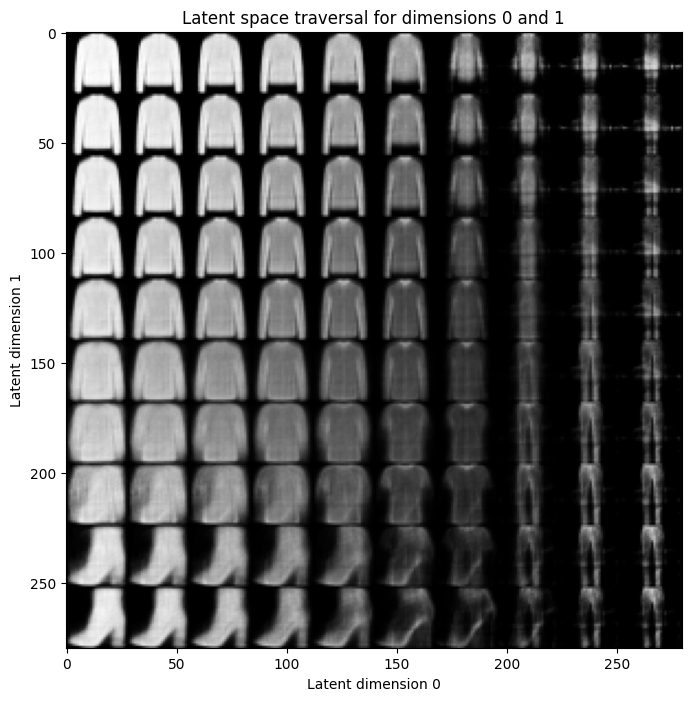

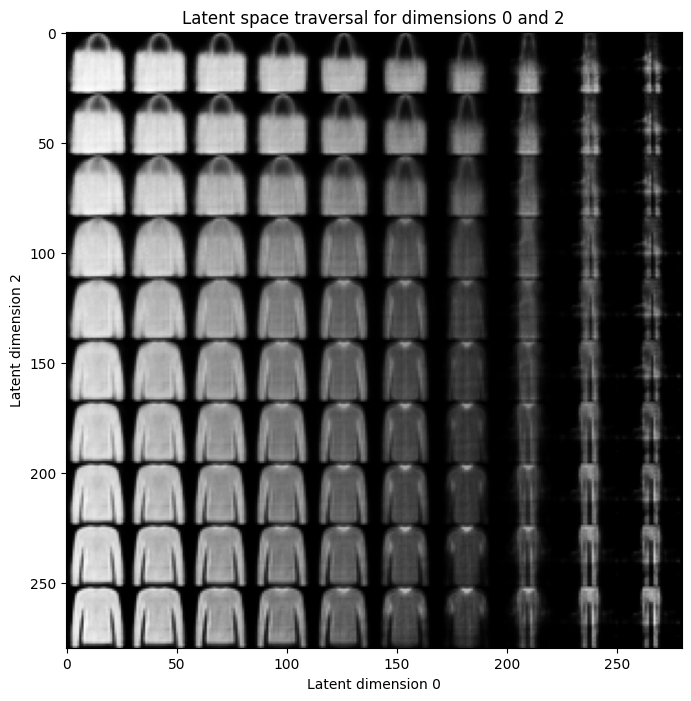

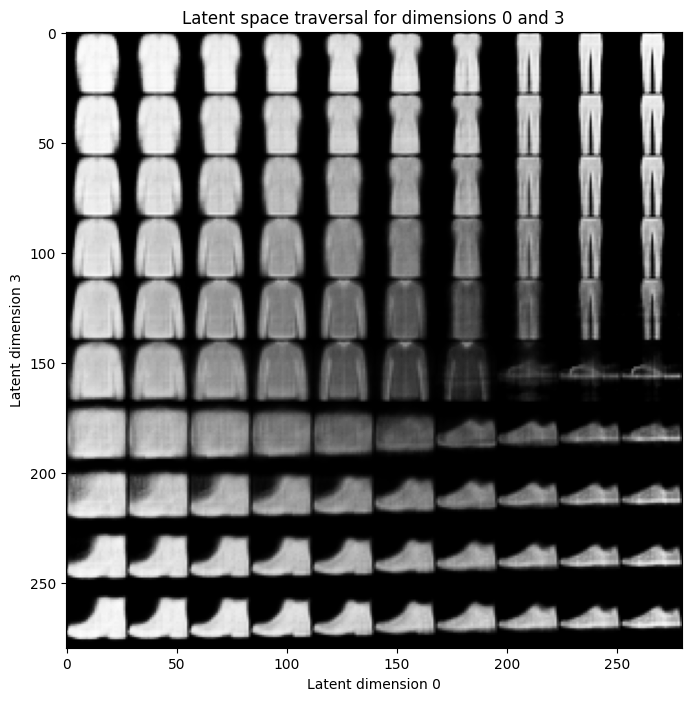

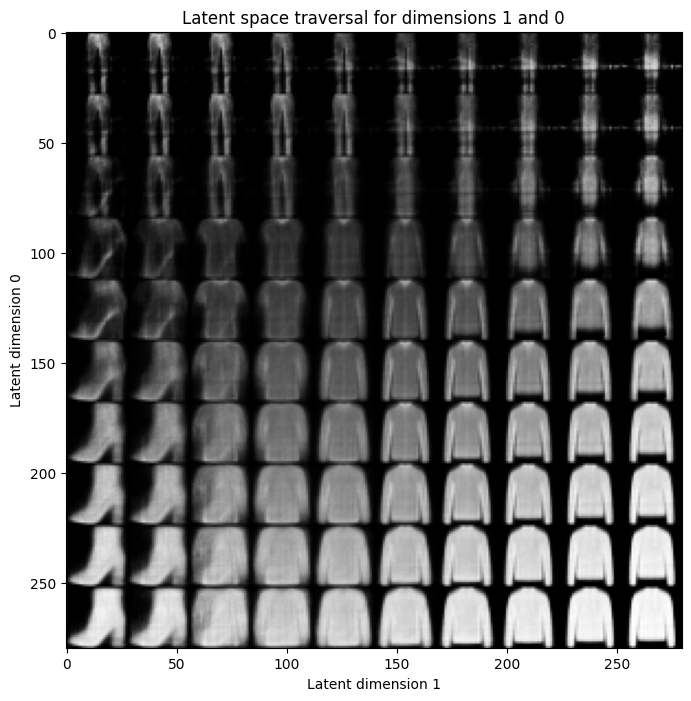

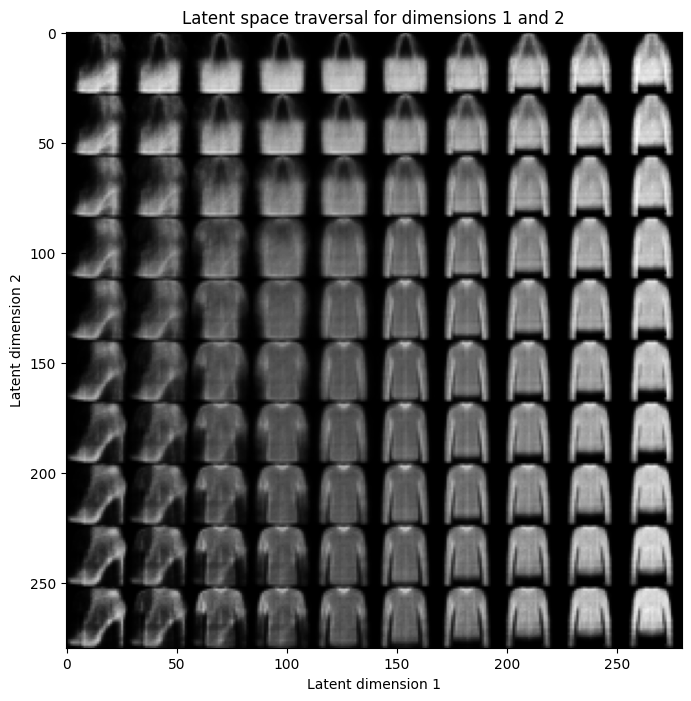

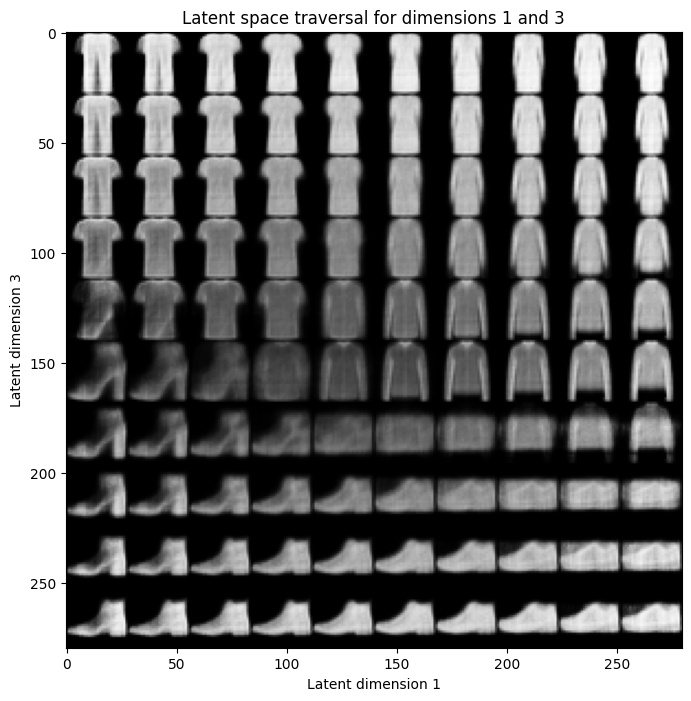

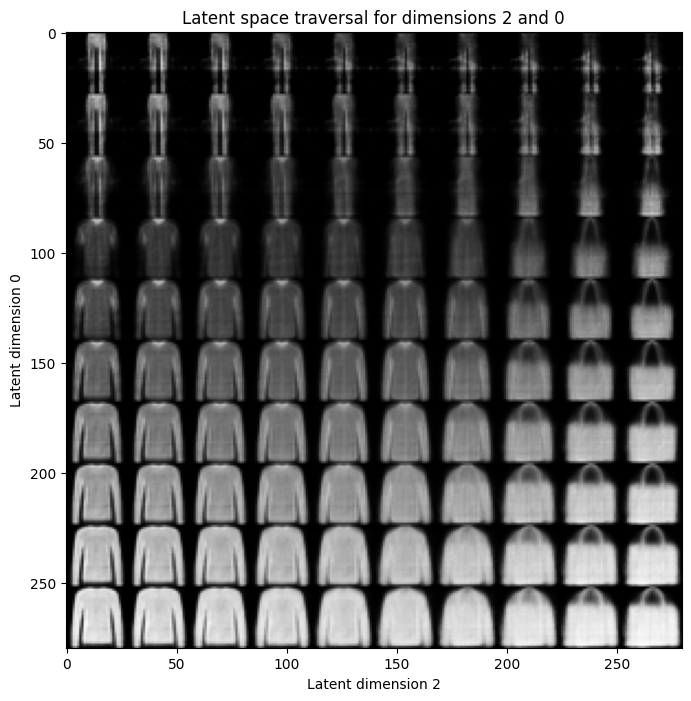

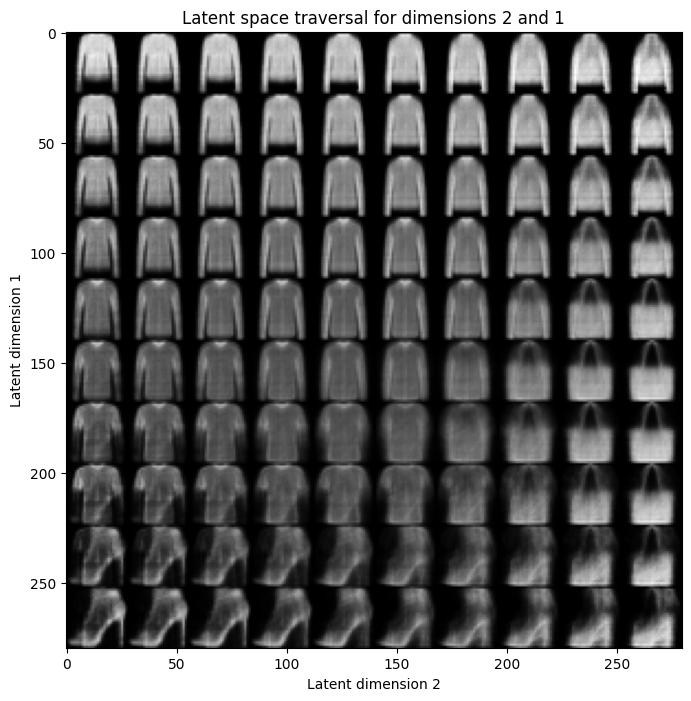

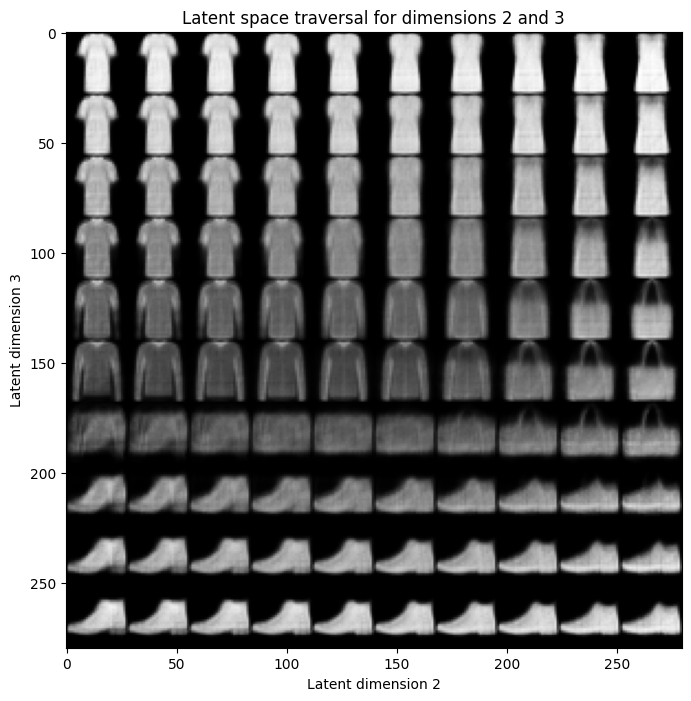

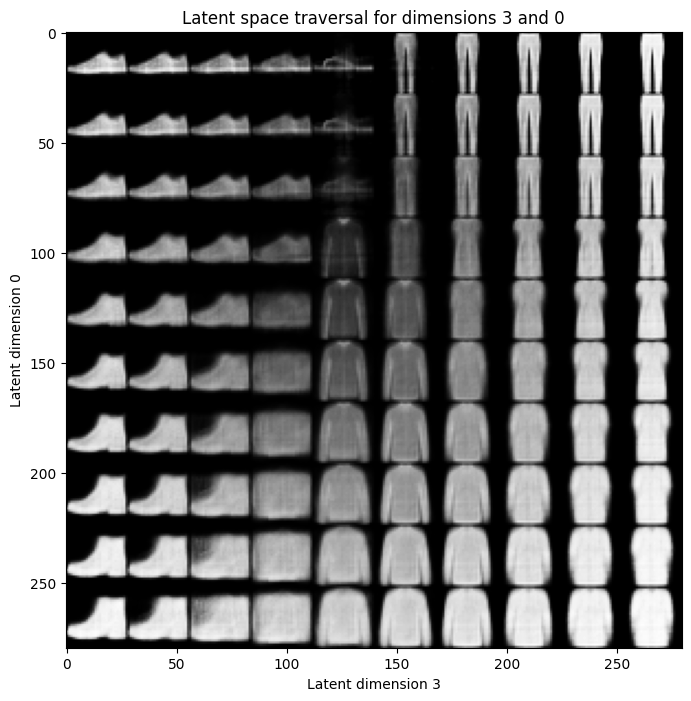

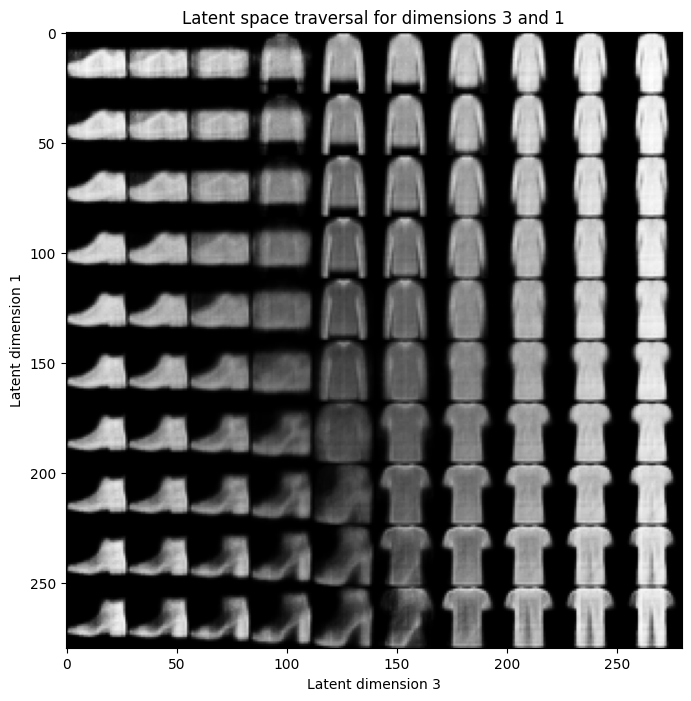

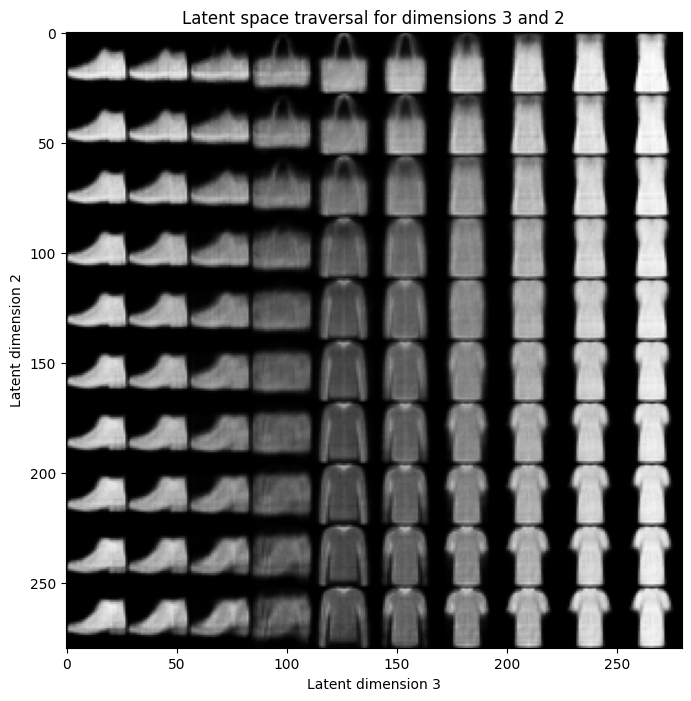

In [14]:
def plot_latents(model, i=0, j=1):
    # FIXME: Plot the image grid
    model.eval()
    n = 10  # 280*280
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))

    for xi, x in enumerate(grid_x):
        for yi, y in enumerate(grid_y):
            z = torch.zeros(model.z_dims)
            z[i] = x
            z[j] = y
            z = z.unsqueeze(0).to(next(model.parameters()).device)
            with torch.no_grad():
                x_decoded = model.decoder(z)
            x_decoded = x_decoded.cpu().numpy().reshape(digit_size, digit_size)
            figure[
                (n - yi - 1) * digit_size : (n - yi) * digit_size,
                xi * digit_size : (xi + 1) * digit_size,
            ] = x_decoded

    # Plot the big image
    plt.figure(figsize=(8, 8))
    plt.imshow(figure, cmap="gray")
    plt.xlabel(f"Latent dimension {i}")
    plt.ylabel(f"Latent dimension {j}")
    plt.title(f"Latent space traversal for dimensions {i} and {j}")
    plt.show()


def plot_zs(model):
    for i in range(model.z_dims):
        for j in range(model.z_dims):
            if i != j:
                plot_latents(model, i, j)


plot_zs(model)

# Diffusion Models

**Question 11:** Complete the three FIXMEs in the below code.

- NOTE: For each of the FIXMEs in this problem, you are provided with a batch of random times `t`. You will need to index into `beta_t` with this time vector `t` to construct your outputs.

1. Calculate $\textbf{x}_t$ from $\textbf{x}_0$ and $\epsilon\sim N(0, \mathbf{I})$ using  Equation 7. Note $\textbf{x}_t$ should have the same shape as $\textbf{x}_0$ and $\epsilon$.
2. Using the variance schedule `beta_t`, calculate `beta_tilde_t` using from the pset document.
2. Using the variance schedule `beta_t`, calculate `mu_tilde_t` using  the pset document. `mu_tilde_t` should have the same shape as `x`.

**Your training should take around 2 minutes per epoch**

In [ ]:
NUM_EPOCHS = 5
TOTAL_TIMESTEPS = 200
scaled_size = 32

# Create the Unet model
model = Unet(
    scaled_size,
    channels=1,
    dim_mults=(
        1,
        2,
        4,
    ),
).to(device)

# We will use the following variance schedule for our diffusion model
beta_t = torch.linspace(0.0001, 0.02, TOTAL_TIMESTEPS)


def forward_sample(x_0, t, e):
    # FIXME: calculate x_t from x_0, e, and t using the equation provided in the homework
    pass


optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(NUM_EPOCHS):
    train_losses = []
    for X, y in tqdm(train_loader):
        optimizer.zero_grad()
        batch_size = X.shape[0]
        batch = X.to(device)

        # Sample a batch of times for training
        t = torch.randint(0, TOTAL_TIMESTEPS, (batch_size,), device=device).long()

        # Calculate the loss
        e = torch.randn_like(batch)
        x_t = forward_sample(batch, t, e)
        e_pred = model(x_t, t)
        loss = F.mse_loss(e, e_pred)

        # Gradient step
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print("Epoch: {} Loss: {}".format(epoch, np.mean(train_losses)))

## Denoising with the learned model

In [ ]:
def reverse_sample(model, x, t, t_index):

    # FIXME: Using beta_t, calculate beta_tilde_t using equation 5 from the pset document
    beta_tilde_t = None
    ########################

    # FIXME: Using beta_t, calculate mu_tilde_t using equation 6 from the pset document
    mu_tilde_t = None
    ########################

    e = torch.randn_like(x)
    return mu_tilde_t + torch.sqrt(beta_tilde_t) * e


@torch.no_grad()
def sample(model):
    shape = (1, 1, scaled_size, scaled_size)
    img = torch.randn(shape, device=device)
    imgs = [img.cpu().numpy()]
    for i in reversed(range(0, TOTAL_TIMESTEPS)):
        img = reverse_sample(model, img, i)
        imgs.append(img.cpu().numpy())
    return imgs

**Question 12:**
Use the calculated `samples` to visualize the model the diffusion model inference over time.  Create a plot with six horizontally-aligned subfigures showing the diffusion model inference $x_t$ for $t\in{\{200, 100, 50, 20, 10, 0\}}$.

In [ ]:
samples = sample(model)
# FIXME: Plot the model inference over time using the samples calculated above